In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!wandb login 9676e3cc95066e4865586082971f2653245f09b4

Appending key for api.wandb.ai to your netrc file: /Users/guydavidson/.netrc
Successfully logged in to Weights & Biases!


In [84]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
from scipy.special import factorial

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib import path as mpath

import pickle
import tabulate
import wandb
from collections import namedtuple

In [152]:
np.set_printoptions(linewidth=160)

## Fetch a single run from WandB

In [5]:
api = wandb.Api()
run = api.run('meta-learning-scaling/sequential-benchmark-baseline/6fmtx2m7')
df = run.history(pandas=True)

In [23]:
print(df.shape)
df[:10]

(118, 70)


,Test AUC,Test Accuracy,"Test Accuracy, Query #1","Test Accuracy, Query #10","Test Accuracy, Query #2","Test Accuracy, Query #3","Test Accuracy, Query #4","Test Accuracy, Query #5","Test Accuracy, Query #6","Test Accuracy, Query #7",...,gradients/fc1.bias,gradients/fc1.weight,gradients/fcout.fc2.bias,gradients/fcout.fc2.weight,gradients/fcout.fc3.bias,gradients/fcout.fc3.weight,gradients/fcout.fc4.bias,gradients/fcout.fc4.weight,gradients/fcout.fc5.bias,gradients/fcout.fc5.weight
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"{'bins': [-0.0011030409950762987, -0.001067508...","{'bins': [-0.0028891866095364094, -0.002791859...","{'bins': [-0.0018628956750035286, -0.001812204...","{'_type': 'histogram', 'values': [1, 0, 0, 2, ...","{'_type': 'histogram', 'values': [1, 0, 1, 0, ...","{'_type': 'histogram', 'values': [2, 1, 4, 5, ...","{'bins': [-0.002993393689393997, -0.0029028125...","{'bins': [-0.002214892767369747, -0.0021436058...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [1, 0, 1, 0, ..."
1,0.754295,74.500000,0.7536,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"{'_type': 'histogram', 'values': [1, 1, 0, 0, ...","{'_type': 'histogram', 'values': [2, 1, 2, 0, ...","{'_type': 'histogram', 'values': [1, 0, 0, 1, ...","{'_type': 'histogram', 'values': [1, 0, 2, 1, ...","{'bins': [-0.002361118793487549, -0.0022836846...","{'values': [1, 3, 5, 6, 6, 8, 13, 27, 37, 39, ...","{'values': [1, 1, 0, 0, 0, 0, 3, 0, 0, 4, 1, 4...","{'_type': 'histogram', 'values': [1, 2, 1, 1, ...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'bins': [-0.018434586003422737, -0.0178585052..."
2,0.881109,88.000000,0.8830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [1, 0, 0, 1, ...","{'_type': 'histogram', 'values': [1, 0, 1, 1, ...","{'values': [1, 0, 1, 1, 5, 1, 1, 3, 10, 6, 8, ...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [1, 0, 0, 1, ...","{'_type': 'histogram', 'values': [1, 0, 2, 0, ...","{'values': [1, 3, 2, 0, 5, 4, 7, 4, 11, 11, 13...","{'values': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","{'bins': [-0.01340036652982235, -0.01298160571..."
3,0.955544,95.250000,0.9572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"{'_type': 'histogram', 'values': [1, 0, 1, 0, ...","{'_type': 'histogram', 'values': [3, 3, 5, 3, ...","{'_type': 'histogram', 'values': [1, 1, 0, 0, ...","{'_type': 'histogram', 'values': [1, 1, 0, 2, ...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'bins': [-0.0051918476819992065, -0.005083194...","{'_type': 'histogram', 'values': [1, 0, 0, 2, ...","{'_type': 'histogram', 'values': [1, 0, 0, 1, ...","{'values': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","{'_type': 'histogram', 'values': [1, 0, 1, 0, ..."
4,0.671759,67.714286,0.7520,NaN,0.6114,NaN,NaN,NaN,NaN,NaN,...,"{'_type': 'histogram', 'values': [2, 0, 0, 0, ...","{'_type': 'histogram', 'values': [1, 1, 1, 0, ...","{'_type': 'histogram', 'values': [2, 0, 1, 1, ...","{'_type': 'histogram', 'values': [3, 0, 6, 5, ...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [1, 0, 0, 1, ...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'bins': [-0.03141821175813675, -0.03043639287...","{'values': [2, 0, 1, 0, 4, 2, 2, 5, 1, 8, 9, 1..."
5,0.712645,70.571429,0.8550,NaN,0.5672,NaN,NaN,NaN,NaN,NaN,...,"{'values': [1, 1, 1, 0, 0, 1, 1, 1, 2, 0, 3, 3...","{'_type': 'histogram', 'values': [2, 2, 4, 4, ...","{'values': [1, 0, 1, 1, 1, 1, 0, 4, 2, 2, 2, 1...","{'_type': 'histogram', 'values': [1, 0, 2, 1, ...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'bins': [-0.010801795870065689, -0.0104331290...","{'_type': 'histogram', 'values': [1, 1, 2, 1, ...","{'bins': [-0.00841599516570568, -0.00812252052...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'_type': 'histogram', 'values': [2, 0, 2, 1, ..."
6,0.713336,71.142857,0.8492,NaN,0.5794,NaN,

## Examples to criterion plot

We discussd plotting the number of examples (for that task) to get back to criterion, as a function of both the total number of tasks the network has learned, and how many times the task was relearned. 

If we just look at the latter, that's easy to plot, since we can just have the number of times the task was learned on the x-axis, and the number of examples on the y-axis. If we want to look at both, that's harder - a 3-D plot? A heatmap in 2-D?

**TODO:** What do we do if the accuracy goes above the threshold and then back below, while training on a given task? I'm assuming for now it doesn't happen, although it theoretically could

First, I can print up both above, in a table .that ends up being upper-triangular. I want a table such that $A[x, y]$ is the number of examples to reach criterion, where $x$ (the row) indicates the number of times the task was learned, and $y$ (the col) indicates how many tasks the network was training on at the time. That is, $A[2, 4]$ should be a task trained on for the 3rd time when the network was training on the fifth task. 

In [158]:
DATASET_CORESET_SIZE = 22500
ACCURACY_THRESHOLD = 0.95
TASK_ACC_COLS = [f'Test Accuracy, Query #{i}' for i in range(1, 11)]


def examples_per_epoch(task, latest_task):
    if task == latest_task:
        return 22500
    
    return 22500 // (latest_task - 1)
            

def parse_run_results(current_run_id=None, current_run=None):
    if current_run_id is None and current_run is None:
        print('Must provide either a current run or its id')
        return
    
    if current_run is None:
        current_run = api.run(f'meta-learning-scaling/sequential-benchmark-baseline/{current_run_id}')
        
    current_df = current_run.history(pandas=True)
    
    examples_to_criterion = np.empty((10, 10))
    examples_to_criterion.fill(np.nan)
    absolute_accuracy = np.empty((9, 9))
    absolute_accuracy.fill(np.nan)
    accuracy_drop = np.empty((9, 9))
    accuracy_drop.fill(np.nan)
    
    first_task_finished = current_df['Test Accuracy, Query #2'].first_valid_index() - 1
    examples_to_criterion[0, 0] = first_task_finished * examples_per_epoch(1, 1)
    absolute_accuracy[0, 0] = current_df['Test Accuracy, Query #1'][first_task_finished + 1]
    accuracy_drop[0, 0] = current_df['Test Accuracy, Query #1'][first_task_finished] - absolute_accuracy[0, 0]

    for current_task in range(2, 11):
        current_task_start = current_df[f'Test Accuracy, Query #{current_task}'].first_valid_index()

        if current_task == 10:
            current_task_end = current_df.shape[0]
        else:
            current_task_end = current_df[f'Test Accuracy, Query #{current_task + 1}'].first_valid_index()

        current_task_subset = current_df[TASK_ACC_COLS][current_task_start:current_task_end] > 0.95

        for task in range(1, current_task + 1):
            number_times_learned = current_task - task + 1
            number_total_tasks = current_task

            examples_to_criterion[number_times_learned - 1, number_total_tasks - 1] = examples_per_epoch(task, current_task) * \
                (current_task_subset[f'Test Accuracy, Query #{task}'].idxmax() - current_task_start + 1)
            
            if current_task < 10:
                absolute_accuracy[number_times_learned - 1, number_total_tasks - 1] = \
                    current_df[f'Test Accuracy, Query #{task}'][current_task_end]
                accuracy_drop[number_times_learned - 1, number_total_tasks - 1] = \
                    current_df[f'Test Accuracy, Query #{task}'][current_task_end - 1] - \
                    absolute_accuracy[number_times_learned - 1, number_total_tasks - 1]
            
    return examples_to_criterion, absolute_accuracy, accuracy_drop

PRINT_HEADERS = ['###'] + [str(x) for x in range(1, 11)]

def pretty_print_results(results, **kwargs):
    result_rows = [[str(i + 1)] + list(results[i]) for i in range(len(results))]
    tab_args = dict(tablefmt='fancy_grid')
    tab_args.update(kwargs)
    print(tabulate.tabulate(result_rows, PRINT_HEADERS, **tab_args))

In [ ]:
examples_to_criterion, absolute_accuracy, accuracy_drop = parse_run_results('6fmtx2m7')
pretty_print_results(examples_to_criterion)
pretty_print_results(absolute_accuracy)
pretty_print_results(accuracy_drop)

In [191]:
Results = namedtuple('Results', ['name', 'mean', 'std'])
RESULT_SET_NAMES = ('Examples to criterion', 'Log examples to criterion', 
                    'New task accuracy', 'New task accuracy delta')


def runs_by_dimension(max_rep_id):
    runs = api.runs('meta-learning-scaling/sequential-benchmark-baseline')
    
    results = ([], [], [])
    
    for run in runs:
        run_id = int(run.description.split('\n')[0][-4:])
        dimension = (run_id // 1000) - 1
        rep = run_id % 1000
        if rep < max_rep_id:
            results[dimension].append(run)
            
    return results


def process_multiple_runs(runs, debug=False):
    examples = []
    log_examples = []
    abs_accuracies = []
    accuracy_drops = []
    
    examples_by_task = np.zeros((30, 10))
    counts_by_task = np.zeros((30, 10))
    
    for run in runs:
        examples_to_criterion, absolute_accuracy, accuracy_drop = parse_run_results(current_run=run)
        examples.append(examples_to_criterion)
        log_examples.append(np.log(examples_to_criterion))
        abs_accuracies.append(absolute_accuracy)
        accuracy_drops.append(accuracy_drop)
        
        for index, task in enumerate(run.config['query_order']):
            task_examples = np.diag(examples_to_criterion, index)
            examples_by_task[task,:10 - index] += task_examples
            counts_by_task[task,:10 - index] += 1

    output = []
    for result_set, name in zip((examples, log_examples, abs_accuracies, accuracy_drops), 
                                RESULT_SET_NAMES):
        output.append(Results(name=name, mean=np.mean(result_set, axis=0), 
                              std=np.std(result_set, axis=0)))

    # to avoid division by zero
    counts_by_task[counts_by_task == 0] = 1
    average_examples_by_task = np.divide(examples_by_task, counts_by_task)
        
    if debug:
        return output, average_examples_by_task, examples
    
    return output, average_examples_by_task

# average_examples, average_abs_acc, average_acc_drop = average_multiple_runs(runs, 150)

In [192]:
first_replication_by_dimension_runs = runs_by_dimension(10)
print('Loaded runs')
first_replication_by_dimension = [process_multiple_runs(run_set) 
                                           for run_set in first_replication_by_dimension_runs]

Loaded runs


In [193]:
six_replications_by_dimension_runs = runs_by_dimension(60)
print('Loaded runs')
six_replications_by_dimension = [process_multiple_runs(run_set) 
                                 for run_set in six_replications_by_dimension_runs]

Loaded runs


## Plot the results

In [284]:
def plot_processed_results(results, title, ylim=None, log_x=False, log_y=False,
                           sem_n=1, shade_error=False, plot_bottom=False, colormap='tab10'):
    figure = plt.figure(figsize=(12, 6 + 6 * plot_bottom))
    NROWS = 1 + plot_bottom
    NCOLS = 2
    
    figure.suptitle(title)
    colors = plt.get_cmap(colormap)
    num_points = results.mean.shape[0]
    
    nonzero_rows, nonzero_cols = np.nonzero(results.mean)
    means = [results.mean[r, c] for (r, c) in zip(nonzero_rows, nonzero_cols)]

    # Accuracy as a function of # times trained on
    num_times_trained_ax = plt.subplot(NROWS, NCOLS, 1)
    num_times_trained_ax.scatter(nonzero_rows + 1, means, 
                                 color=[colors(x / num_points) for x 
                                        in abs(nonzero_cols - nonzero_rows)])
    
    # TODO: verify this does the right thing for the accuracies. It probably won't
    for task in range(num_points):
        x_values = np.arange(1, num_points - task + 1)
        y_means = np.diag(results.mean, task)
        y_stds = np.diag(results.std, task) / (sem_n ** 0.5)
        
        num_times_trained_ax.plot(x_values, y_means, color=colors(task / 10))
        if shade_error:
            num_times_trained_ax.fill_between(x_values, y_means - y_stds, y_means + y_stds,
                                             color=colors(task / 10), alpha=0.25)
        
    if ylim is not None:
        num_times_trained_ax.set_ylim(ylim)

    if log_x:
        num_times_trained_ax.set_xscale("log", nonposx='clip')
    if log_y:
#         num_times_trained_ax.set_yscale("log", nonposy='clip')
        y_min, y_max = num_times_trained_ax.get_ylim()
        y_min_pow_10 = np.ceil(y_min * np.log10(np.e))
        y_max_pow_10 = np.ceil(y_max * np.log10(np.e))
        
        y_powers_10 = np.arange(y_min_pow_10, y_max_pow_10)
        y_ticks = np.log(10) * y_powers_10
        y_tick_labels = [f'$10^{{ {int(y_tick)} }}$' for y_tick in y_powers_10]
        
        num_times_trained_ax.set_yticks(y_ticks)
        num_times_trained_ax.set_yticklabels(y_tick_labels)
        
    num_times_trained_ax.set_xlabel(f'{log_x and "log(" or ""}Number of times trained on{log_x and ")" or ""}')
#     num_times_trained_ax.set_ylabel(f'{log_y and "log(" or ""}{results.name}{log_y and ")" or ""}')
    num_times_trained_ax.set_ylabel(f'{results.name}')
    num_times_trained_ax.set_title(f'{results.name} vs. times trained on')
    
    # Accuracy as a function of how many total tasks
    num_current_tasks_ax = plt.subplot(NROWS, NCOLS, 2)
#     num_current_tasks_ax.scatter(nonzero_cols + 1, results.mean, 
#                                  color=[colors(x / 10) for x in abs(nonzero_cols - nonzero_rows)])
    for task in range(num_points):
        x_values = np.arange(task + 1, num_points + 1)
#         y_means = np.diag(results.mean, task)
        y_means = results.mean[task, task:]
#         y_stds = np.diag(results.std, task) / (sem_n ** 0.5)
        y_stds = results.std[task, task:] / (sem_n ** 0.5)
        num_current_tasks_ax.scatter(x_values, y_means, color=colors(task / 10))
        num_current_tasks_ax.plot(x_values, y_means, color=colors(task / 10))
        if shade_error:
            num_current_tasks_ax.fill_between(x_values, y_means - y_stds, y_means + y_stds,
                                             color=colors(task / 10), alpha=0.25)
    
    if ylim is not None:
        num_current_tasks_ax.set_ylim(ylim)
    
    if log_x:
        num_current_tasks_ax.set_xscale("log", nonposx='clip')
    if log_y:
#         num_current_tasks_ax.set_yscale("log", nonposy='clip')
        y_min, y_max = num_current_tasks_ax.get_ylim()
        y_min_pow_10 = np.ceil(y_min * np.log10(np.e))
        y_max_pow_10 = np.ceil(y_max * np.log10(np.e))
        
        y_powers_10 = np.arange(y_min_pow_10, y_max_pow_10)
        y_ticks = np.log(10) * y_powers_10
        y_tick_labels = [f'$10^{{ {int(y_tick)} }}$' for y_tick in y_powers_10]
        
        num_current_tasks_ax.set_yticks(y_ticks)
        num_current_tasks_ax.set_yticklabels(y_tick_labels)
        
    num_current_tasks_ax.set_xlabel(f'{log_y and "log(" or ""}Number of tasks trained on{log_y and ")" or ""}')
    num_current_tasks_ax.set_ylabel(f'{log_y and "log(" or ""}{results.name}{log_y and ")" or ""}')
    num_current_tasks_ax.set_title(f'{results.name} vs. tasks trained on')
    
#     if plot_bottom:
#         # Accuracy as a function of both
#         both_ax = plt.subplot(NROWS, NCOLS, 3, projection='3d')
#         both_ax.scatter(nonzero_rows, nonzero_cols, values)

#         both_ax.set_zscale("log")
#         both_ax.set_xlabel('Number of times trained on')
#         both_ax.set_ylabel('Number of tasks trained on')
#         both_ax.set_zlabel('log(examples to criterion)')
#         both_ax.set_title('# examples to criterion vs. both')

#         # Accuracy as a function of both in a heatmap
#         heatmap_ax = plt.subplot(NROWS, NCOLS, 4)
#         heatmap_ax.imshow(np.log(examples_to_criterion + 1), cmap='YlOrRd')
#         for i in range(10):
#             for j in range(i, 10):
#                 text = heatmap_ax.text(j, i, examples_to_criterion[i, j],
#                                ha="center", va="center", color="w", fontsize=8)


#         heatmap_ax.set_xlabel('Number of times trained on')
#         heatmap_ax.set_ylabel('Number of tasks trained on')
#         heatmap_ax.set_title('Heatmap of # examples to criterion')
    
    plt.show()



## Plot the number of examples by dimension

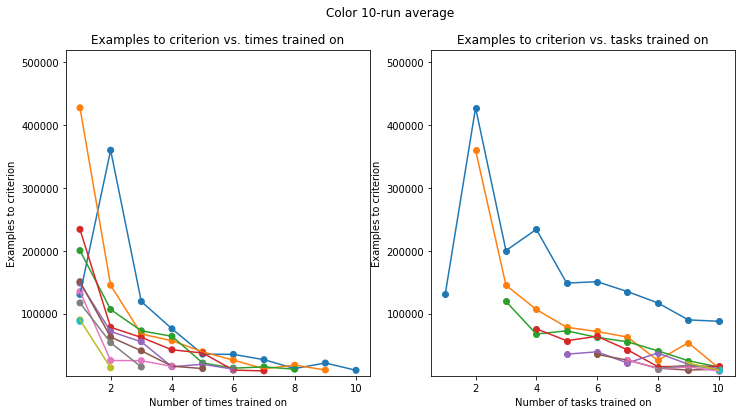

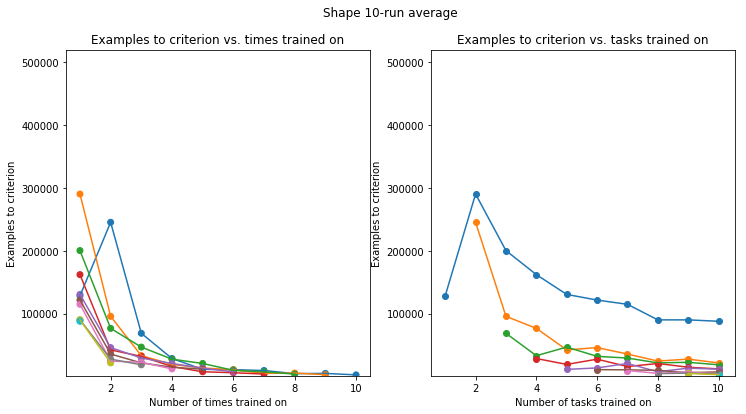

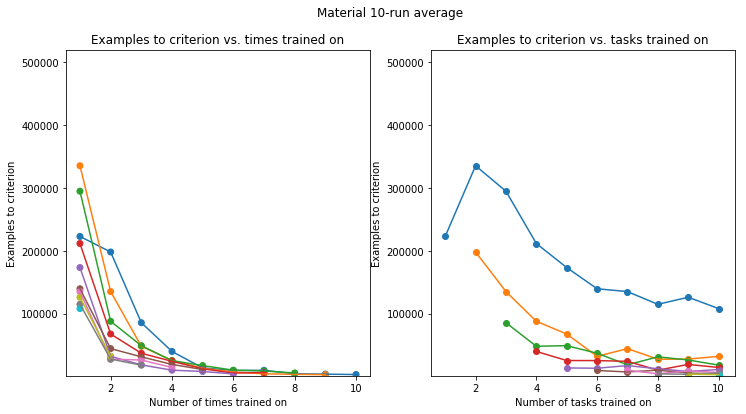

In [285]:
ylim = (1000, 520000)

plot_processed_results(first_replication_by_dimension[0][0][0], 'Color 10-run average', ylim)
plot_processed_results(first_replication_by_dimension[1][0][0], 'Shape 10-run average', ylim)
plot_processed_results(first_replication_by_dimension[2][0][0], 'Material 10-run average', ylim)

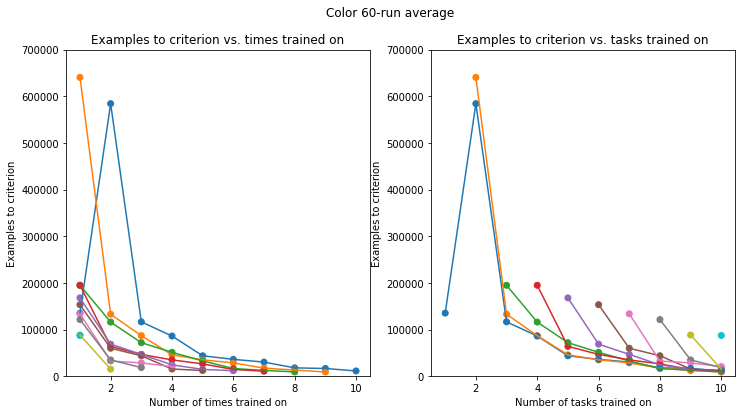

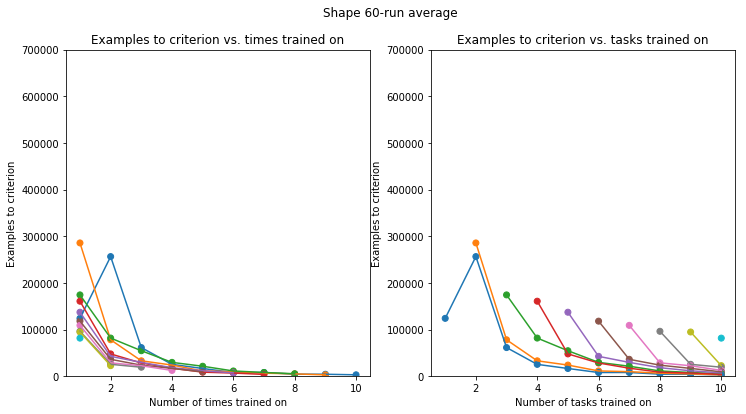

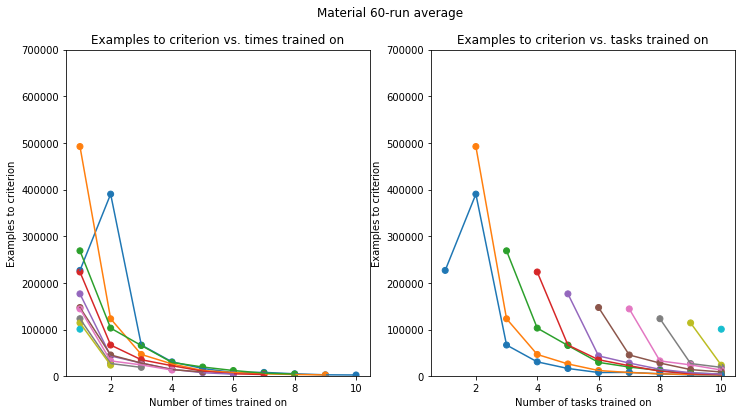

In [233]:
ylim = (1000, 700000)

plot_processed_results(six_replications_by_dimension[0][0][0], 'Color 60-run average', ylim)
plot_processed_results(six_replications_by_dimension[1][0][0], 'Shape 60-run average', ylim)
plot_processed_results(six_replications_by_dimension[2][0][0], 'Material 60-run average', ylim)

## Plot the log of the number of examples to criterion, in each dimension, with error bars

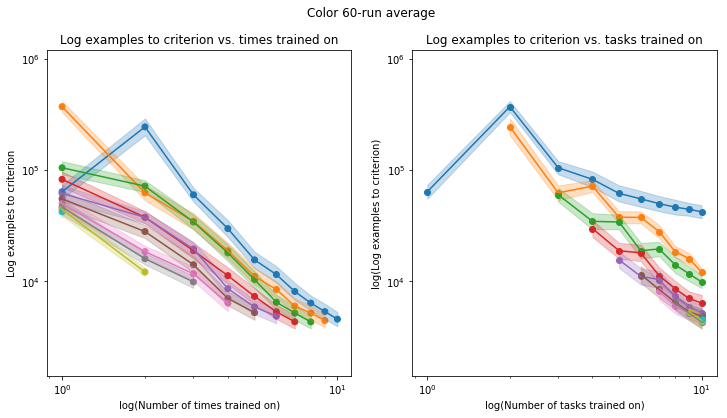

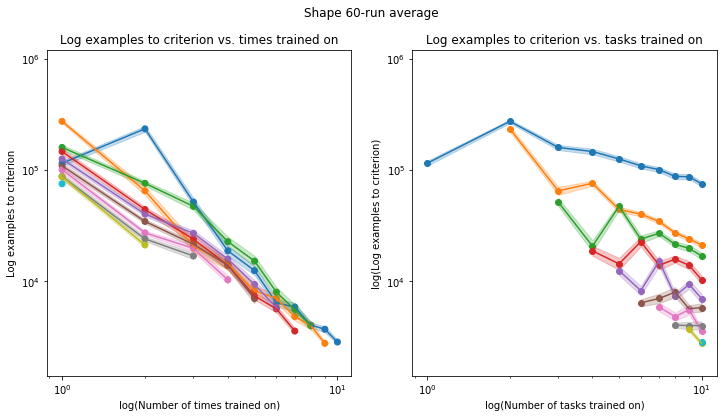

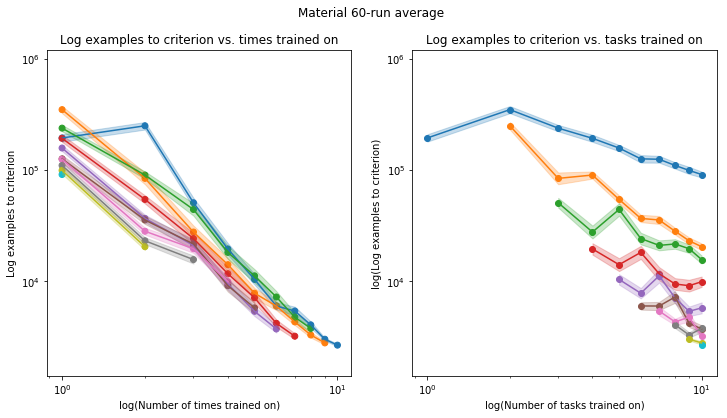

In [286]:
ylim = (7.25, 14)

plot_processed_results(six_replications_by_dimension[0][0][1], 'Color 60-run average', 
                       ylim, log_x=True, log_y=True, sem_n=60, shade_error=True)
plot_processed_results(six_replications_by_dimension[1][0][1], 'Shape 60-run average', 
                       ylim, log_x=True, log_y=True, sem_n=60, shade_error=True)
plot_processed_results(six_replications_by_dimension[2][0][1], 'Material 60-run average', 
                       ylim, log_x=True, log_y=True, sem_n=60, shade_error=True)

## Plot the absolute accuracy after introducing a new task

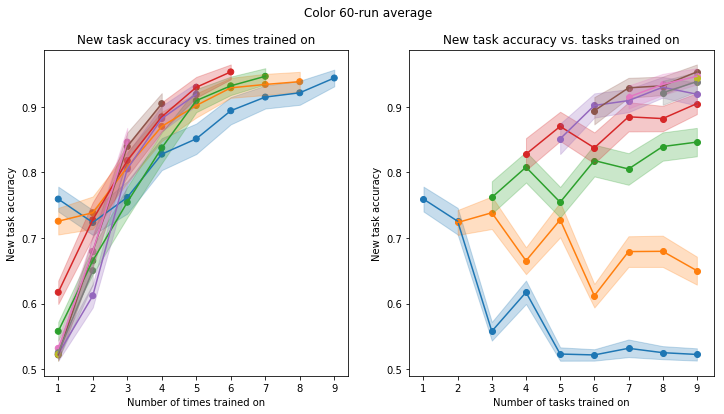

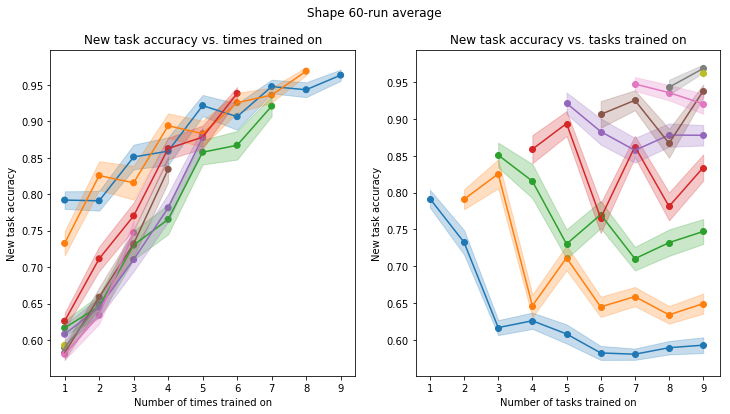

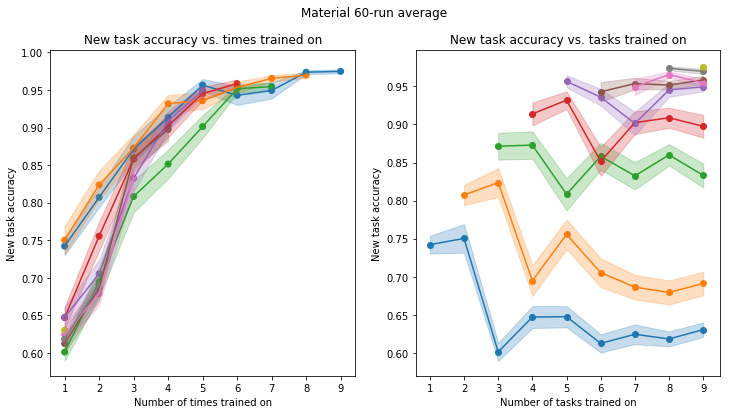

In [287]:
ylim = None

plot_processed_results(six_replications_by_dimension[0][0][2], 'Color 60-run average', 
                       ylim, log_x=False, log_y=False, sem_n=60, shade_error=True)
plot_processed_results(six_replications_by_dimension[1][0][2], 'Shape 60-run average', 
                       ylim, log_x=False, log_y=False, sem_n=60, shade_error=True)
plot_processed_results(six_replications_by_dimension[2][0][2], 'Material 60-run average', 
                       ylim, log_x=False, log_y=False, sem_n=60, shade_error=True)

## Plot the accuracy drop after introducing a new task

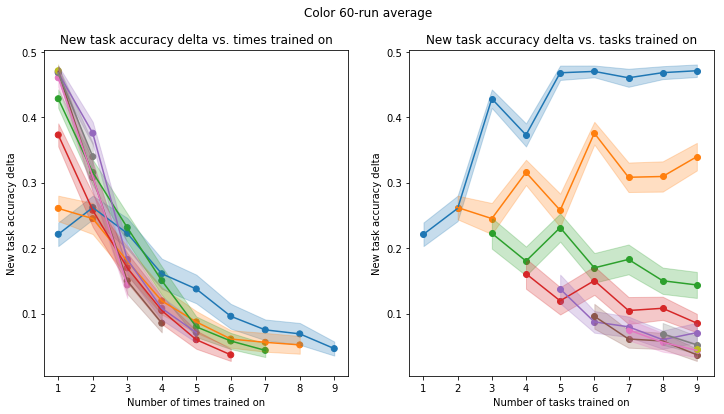

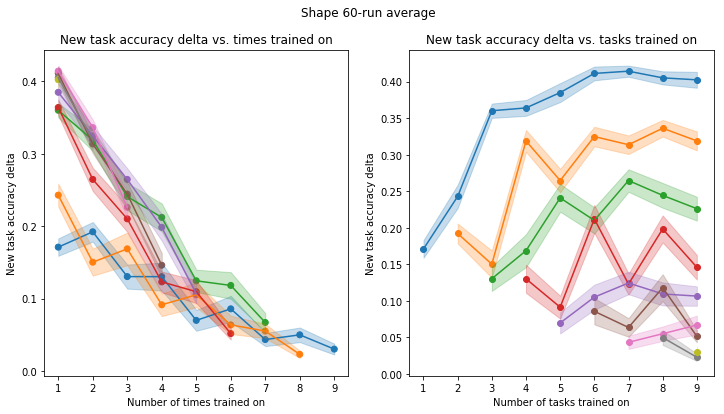

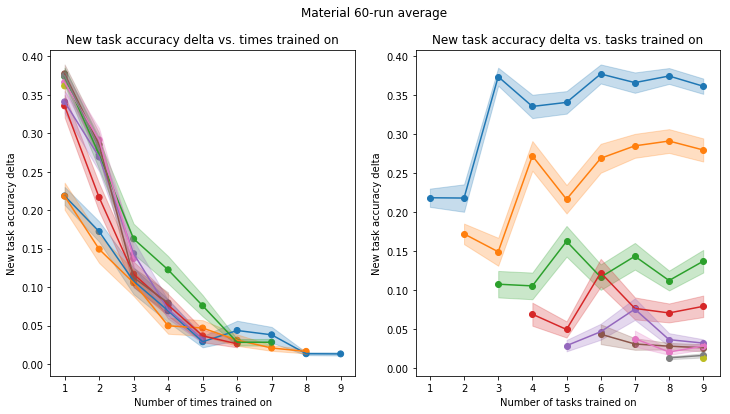

In [288]:
ylim = None

plot_processed_results(six_replications_by_dimension[0][0][3], 'Color 60-run average', 
                       ylim, log_x=False, log_y=False, sem_n=60, shade_error=True)
plot_processed_results(six_replications_by_dimension[1][0][3], 'Shape 60-run average', 
                       ylim, log_x=False, log_y=False, sem_n=60, shade_error=True)
plot_processed_results(six_replications_by_dimension[2][0][3], 'Material 60-run average', 
                       ylim, log_x=False, log_y=False, sem_n=60, shade_error=True)

# Scratch work

## Looking for outlines and analyzing the skewness of these distributions

In [160]:
from scipy.stats import skew, skewtest

In [165]:
output, examples = process_multiple_runs(six_replications_by_dimension_runs[1], debug=True)

In [166]:
ex = np.array(examples)

(array([16.,  0., 19.,  0.,  8.,  0.,  8.,  0.,  3.,  0.,  0.,  0.,  3.,  0.,  1.,  0.,  0.,  0.,  0.,  2.]),
 array([ 2500.,  3750.,  5000.,  6250.,  7500.,  8750., 10000., 11250., 12500., 13750., 15000., 16250., 17500., 18750., 20000., 21250., 22500., 23750., 25000.,
        26250., 27500.]),
 <a list of 20 Patch objects>)

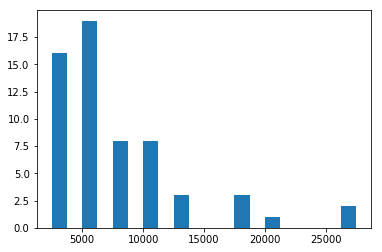

In [167]:
plt.hist(ex[:,5,9], bins=20)

In [168]:
pretty_print_results(skew(ex),  floatfmt=".3f")

╒═══════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═══════╕
│   ### │       1 │       2 │       3 │       4 │       5 │       6 │       7 │       8 │       9 │    10 │
╞═══════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═══════╡
│     1 │   0.302 │   2.829 │   1.093 │   0.096 │   0.644 │   0.691 │   0.630 │   0.923 │   0.944 │ 0.696 │
├───────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼───────┤
│     2 │ nan     │   2.132 │   0.702 │   0.479 │   0.269 │   0.982 │   0.603 │   1.018 │   0.689 │ 1.133 │
├───────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼───────┤
│     3 │ nan     │ nan     │   1.243 │   1.922 │   1.199 │   0.546 │   0.332 │   1.127 │   1.307 │ 1.237 │
├───────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼───────┤
│     4 │ nan     │ nan     

In [169]:
res = skewtest(ex)

/Users/guydavidson/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/guydavidson/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/guydavidson/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [170]:
res.pvalue < 0.001

/Users/guydavidson/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


array([[False,  True, False, False, False, False, False, False, False, False],
       [False,  True, False, False, False, False, False, False, False,  True],
       [False, False,  True,  True,  True, False, False,  True,  True,  True],
       [False, False, False,  True,  True,  True, False, False, False, False],
       [False, False, False, False,  True,  True,  True,  True,  True,  True],
       [False, False, False, False, False,  True,  True,  True,  True,  True],
       [False, False, False, False, False, False,  True,  True,  True, False],
       [False, False, False, False, False, False, False,  True,  True,  True],
       [False, False, False, False, False, False, False, False,  True,  True],
       [False, False, False, False, False, False, False, False, False,  True]])

## Analyzing the average number of example for each actual query/task

In [207]:
query_difficulty = sum([r[1] for r in six_replications_by_dimension])
query_names = ['blue', 'brown', 'cyan', 'gray', 'green', 'orange', 'pink',
       'purple', 'red', 'yellow', 'cone', 'cube', 'cylinder',
       'dodecahedron', 'ellipsoid', 'octahedron', 'pyramid', 'rectangle',
       'sphere', 'torus', 'chain_mail', 'marble', 'maze', 'metal',
       'metal_weave', 'polka', 'rubber', 'rug', 'tiles', 'wood_plank']
dimension_names = ['color', 'shape', 'texture']

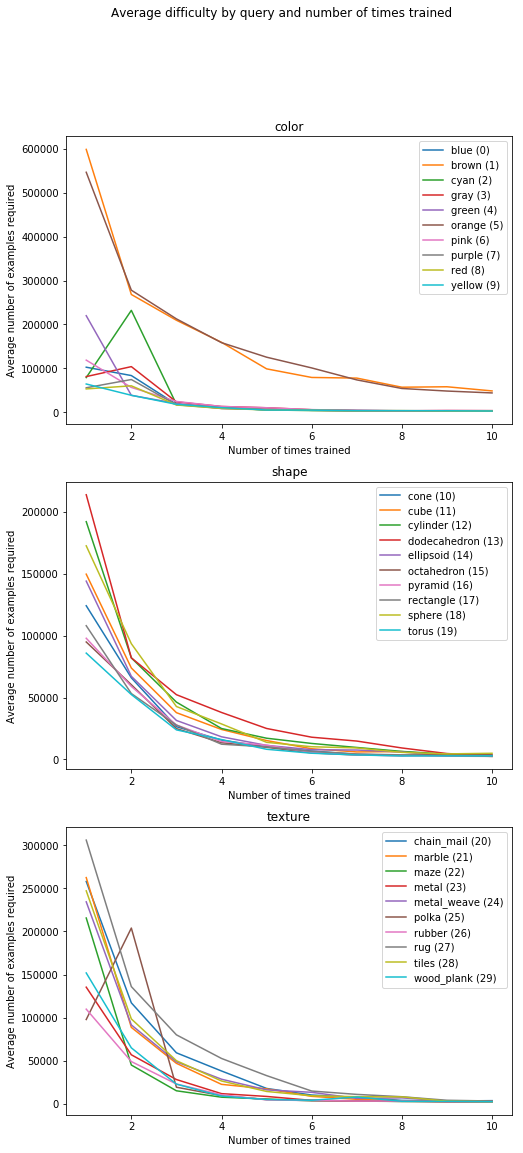

In [269]:
plt.figure(figsize=(8, 18))

plt.suptitle('Average difficulty by query and number of times trained')

for i in range(3):
    ax = plt.subplot(3, 1, i + 1)
    x_values = range(1, 11)
    
    for query_id in range(i * 10, (i + 1) * 10):
        ax.plot(x_values, query_difficulty[query_id,:], label=f'{query_names[query_id]} ({query_id})')
    
    ax.set_title(dimension_names[i])
    ax.set_xlabel('Number of times trained')
    ax.set_ylabel('Average number of examples required')
    ax.legend(loc='best')
    

plt.show()